# Explaining brain stroke factors with shap

## Task A

### 1. Train model
For this task I will prepare the data in the same way as in the first homework.

In [3]:
import pandas as pd
from sklearn.preprocessing import minmax_scale, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("brain_stroke.csv")

enc = OrdinalEncoder()
df[["Residence_type", "ever_married", "gender"]] = enc.fit_transform(df[["Residence_type", "ever_married", "gender"]])
df = pd.get_dummies(df, columns=["work_type"])
df = df.drop(columns=["smoking_status"])
df[['age','avg_glucose_level','bmi']] = minmax_scale(df[['age','avg_glucose_level','bmi']])

X = df.drop("stroke", axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=5)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

As in previous homework I will train RandomForestClassifier.

In [4]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

### 2. Model's prediction on selected samples
I selected two random samples with setted random state that the results will be repeatable. One of the people has a positive prediction and the other a negative one, people differ mainly in age and type of employment.

In [5]:
samples = X_test.reset_index(drop=True).sample(2, random_state=0)
print("Random forest predicted labels:", rfc.predict(samples))
print("Random forest predicted probability:", rfc.predict_proba(samples))
print(samples)

Random forest predicted labels: [1 0]
Random forest predicted probability: [[0.31137129 0.68862871]
 [0.78021784 0.21978216]]
      gender       age  hypertension  heart_disease  ever_married  \
1068     0.0  0.951172             0              0           1.0   
124      0.0  0.572754             0              0           1.0   

      Residence_type  avg_glucose_level       bmi  work_type_Govt_job  \
1068             0.0           0.250900  0.481375                   0   
124              0.0           0.261102  0.730659                   1   

      work_type_Private  work_type_Self-employed  work_type_children  
1068                  0                        1                   0  
124                   0                        0                   0  


### 3, 6. Variable attributions and their differences across the dalex and shap packages
In both observations using shap and also dalex libary, age turned out to be the key feature. In the shap solution BMI seems to be a bit more important, while in the dalex solution the type of work.

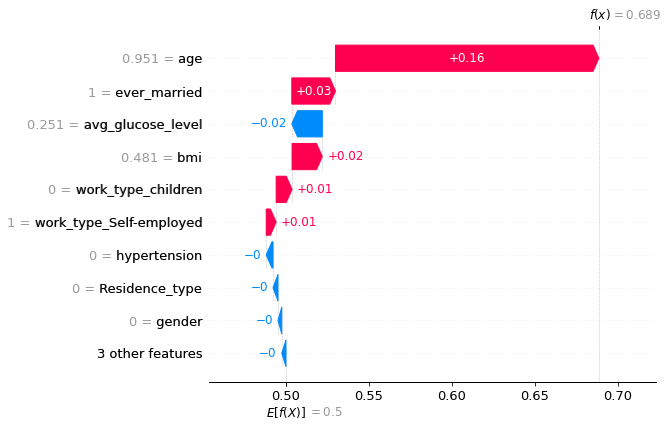

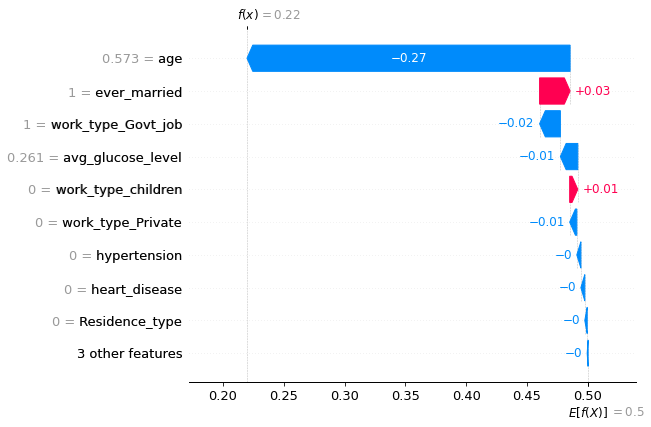

In [6]:
import shap
import dalex

shap_explainer = shap.TreeExplainer(rfc)
shap_values = shap_explainer(X_test)
shap.waterfall_plot(shap_values[samples.index.values[0], :, 1])
shap.waterfall_plot(shap_values[samples.index.values[1], :, 1])

In [39]:
dalex_explainer = dalex.Explainer(rfc, X_test, y_test)
dalex_explainer.predict_parts(samples.iloc[[0]], 'shap', random_state=1).plot()
dalex_explainer.predict_parts(samples.iloc[[1]], 'shap', random_state=1).plot()

Preparation of a new explainer is initiated

  -> data              : 1246 rows 12 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1246 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x16b288940> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0177, mean = 0.342, max = 0.792
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.792, mean = -0.291, max = 0.836
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



![1.png]
![2.png]

### 4. Two observations in the dataset, such that they have different variables of the highest importance

After reading the original features of people with index 100 and index 103, we find out that people are of similar age (50, 55). A similar BMI, which, based on Wikipedia data, is optimal for this age. However, they differ in gender, place of residence and glucose index. However, analyzing the shap values, we find out that for a woman, the strongest influence on the correct prediction of not being at risk of stroke is the BMI index, while for a man, age plays a major role.

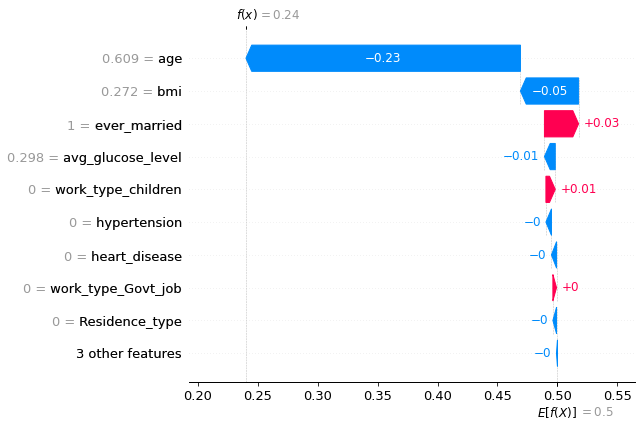

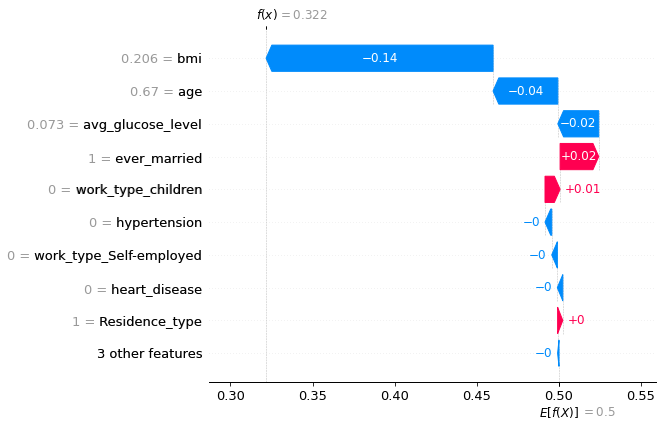

     gender   age  hypertension  heart_disease ever_married work_type  \
3698   Male  50.0             0              0          Yes   Private   

     Residence_type  avg_glucose_level   bmi smoking_status  
3698          Rural             119.77  23.5        Unknown  
3698    0
Name: stroke, dtype: int64
      gender   age  hypertension  heart_disease ever_married work_type  \
3029  Female  55.0             0              0          Yes   Private   

     Residence_type  avg_glucose_level   bmi smoking_status  
3029          Urban              71.02  21.2   never smoked  
3029    0
Name: stroke, dtype: int64


In [24]:
df_original = pd.read_csv("brain_stroke.csv")
X = df_original.drop("stroke", axis=1)
y = df_original["stroke"]
_, X_test_original, _, y_test_original = train_test_split(X, y, shuffle=True, random_state=5)

shap.waterfall_plot(shap_values[100, :, 1])
print(X_test_original.iloc[[100]])
print(y_test_original.iloc[[100]])

shap.waterfall_plot(shap_values[103, :, 1])
print(X_test_original.iloc[[103]])
print(y_test_original.iloc[[103]])

### 5. (If possible) Select one variable X and find two observations in the dataset such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution.
After checking the maximum and minimum shap values for the age feature it seems that average age negatively affects predictions, and old age positively affects.

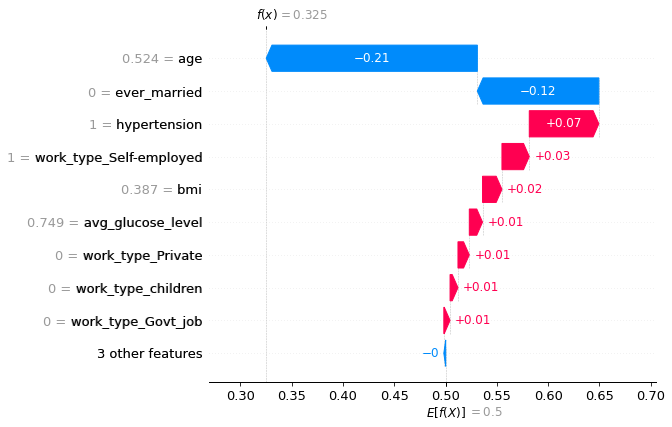

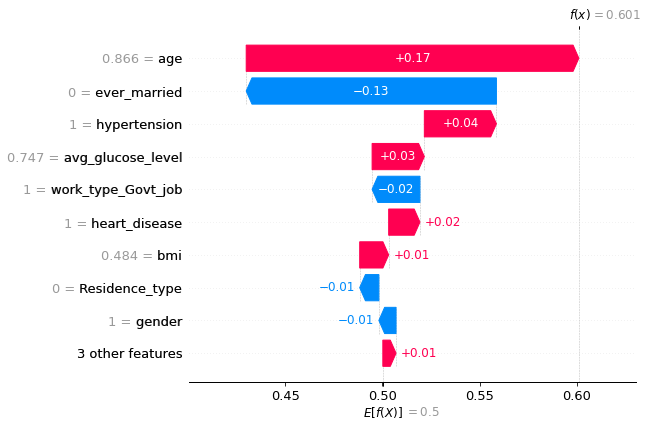

In [35]:
import numpy as np
values = shap_values[:, 0, 1].values

sample1 = np.argmax(values)
sample2 = np.argmin(values)

shap.waterfall_plot(shap_values[sample1, :, 1])
shap.waterfall_plot(shap_values[sample2, :, 1])

## Task B
Calculate Shapley values for player A given the following value function
v() = 0
v(A) = 20
v(B) = 20
v(C) = 60
v(A,B) = 60
v(A,C) = 70
v(B,C) = 70
v(A,B,C) = 100

### Solution
We have six permutations:
ABC, A contribution = v(A) = 20
ACB A contribution = v(A) = 20
BAC, A contribution = v(A, B) - v(B) = 60 - 20 = 40
BCA, A contribution = v(A, B, C) - v(B, C) = 100 - 70 = 30
CAB, A contribution = v(A, C) - v(C) = 70 - 60 = 10
CBA, A contribution = v(A, B, C) - v(B, C) = 100 - 70 = 30
Sum A contributions over all permutations is 20 + 20 + 40 + 30 + 10 + 30 = 150, so the Shapley value for A is 150/6 = 25